In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from assimilation_schemes import OI

plt.style.use('seaborn')

In [2]:
def lorenz63_fdm(x0, ts, sigma=10, r=28, b=8/3):
    """Solve lorenz63 with finit difference method"""    
    size = ts.size
    dt = ts[1] - ts[0]
    
    x = np.zeros((size,))
    y = np.zeros((size,))
    z = np.zeros((size,))
    x[0] = x0[0]
    y[0] = x0[1]
    z[0] = x0[2]
    
    for i in range(1, size):
        x[i] = x[i-1] + sigma * (y[i-1] - x[i-1]) * dt
        y[i] = y[i-1] + (r*x[i-1] - y[i-1] - x[i-1]*z[i-1]) * dt
        z[i] = z[i-1] + (x[i-1]*y[i-1] - b*z[i-1]) * dt
    
    return np.vstack((x, y, z))

### Nature Run

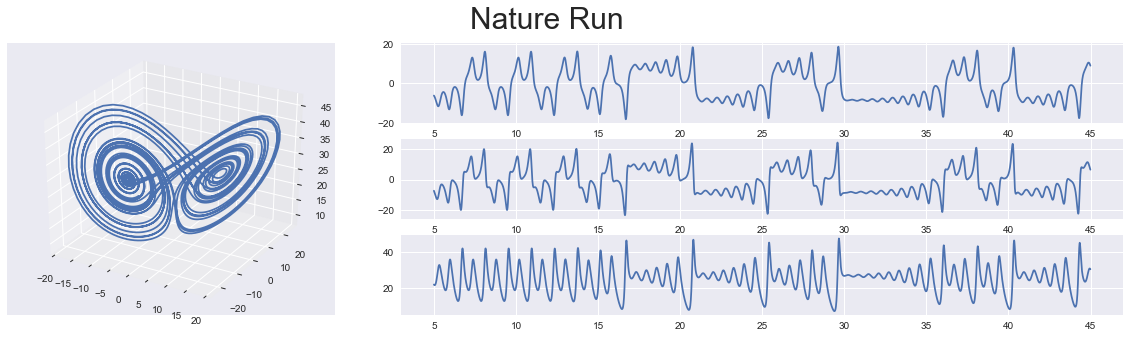

In [3]:
## X = [[x0, x1, x2, ....],
##      [y0, y1, y2, ....],
##      [z0, z1, z2, ....]]


# spin up
spinup_time = 5
dt = 0.01
#X0 = np.array([[10.1], [-0.5], [40.1]])
X0_nature = np.array([[0], [5], [30]])
X_spn = lorenz63_fdm(X0_nature.ravel(), np.arange(0, spinup_time, dt))

# save nature run
time = 40
dt = 0.01
ts = np.arange(spinup_time, spinup_time+time, dt)
X0 = X_spn[:,[-1]]
X_nature = lorenz63_fdm(X0.ravel(), ts)

# plot nature run
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(nrows=3, ncols=3)

ax_line1 = fig.add_subplot(gs[0,1:])
ax_line2 = fig.add_subplot(gs[1,1:])
ax_line3 = fig.add_subplot(gs[2,1:])
ax_3d = fig.add_subplot(gs[:,0], projection='3d')

ax_line1.plot(ts, X_nature[0,:])
ax_line2.plot(ts, X_nature[1,:])
ax_line3.plot(ts, X_nature[2,:])
ax_3d.plot(X_nature[0,:], X_nature[1,:], X_nature[2,:])

fig.suptitle('Nature Run', fontsize=30);

### Simulated Obs

In [16]:
def gen_random_normal(mean, var, size, random_state=None):
    """
    Generate random gaussian distribution numbers
    
    Parameters:
    ----------
    mean, var: scaler or array-like.
        If array-like, its length should equal to 'size'.
    size: int
        The amount of random numbers.
    random_state: int
        If None, np.random.randint(0, 99) will be used.
        
    Return:
    ------
    An 1d array of random numbers.
    """
    if random_state is None:
        random_state = np.random.randint(0, 99)
        
    mean = np.array(mean)
    var = np.array(var)
    
    rng = np.random.RandomState(random_state)
    result = rng.randn(max(mean.size, var.size, size))
    result = (result + mean) * np.sqrt(var)
    return result

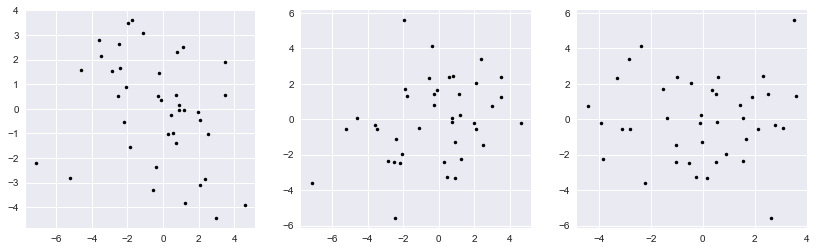

In [17]:
# observation parameters for each variables
obs_mean = [0, 0, 0]
obs_var = [5, 5, 5]
random_state = [20, 21, 22]

# assimilate observation parameters
obs_timeintv = 1
cycle_num = int(time / obs_timeintv)

# construct observation error
X_obs_err = np.zeros((3, cycle_num))
for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
    X_obs_err[irow,:] = gen_random_normal(obsm, obsv, cycle_num, rst)
    
X_obs = X_nature[:,::int(obs_timeintv/dt)] + X_obs_err

# plot observation errors
fig, axs = plt.subplots(figsize=(14, 4), nrows=1, ncols=3)
axs[0].plot(X_obs_err[0], X_obs_err[1], 'k.')
axs[1].plot(X_obs_err[0], X_obs_err[2], 'k.')
axs[2].plot(X_obs_err[1], X_obs_err[2], 'k.')

### Initial value

In [18]:
# spin up and get initial condition for experiments
# random_state=9 is very close to nature run
X0 = X0_nature + gen_random_normal(0, 5, size=1, random_state=30)
X_spn = lorenz63_fdm(X0.ravel(), np.arange(0, spinup_time, dt))

X_ini = X_spn[:,[-1]]
X_ini

array([[-5.22694966],
       [-6.44985479],
       [20.87602827]])

### KF

In [19]:
# from iterative NMC in test2
Pb = np.array([
    [ 95.92487549, 108.82721654,  13.52170192],
    [108.82721654, 135.97355097,  18.39642468],
    [ 13.52170192,  18.39642468,  64.98710037]
])

R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)

In [20]:
#def M(xi, yi, zi, dt, sigma=10, r=28, b=8/3):
#    M = np.array([
#        [-sigma, sigma, 0],
#        [r, -1, -xi],
#        [0.5*yi, 0.5*xi, -b]
#    ]) * dt
#    return M

def M(xi, yi, zi, dt, sigma=10, r=28, b=8/3):
    M = np.array([
        [1-sigma*dt, sigma*dt, 0],
        [r*dt, 1-dt, -xi*dt],
        [0, xi*dt, 1-b*dt]
    ])
    return M

M(X_ini[0,0], X_ini[1,0], X_ini[2,0], dt)

array([[ 0.9       ,  0.1       ,  0.        ],
       [ 0.28      ,  0.99      ,  0.0522695 ],
       [ 0.        , -0.0522695 ,  0.97333333]])

========Some Parameters=========
cycle length (time interval between two observations): 1 sec
number of cycle: 40
dt = 0.01 sec
initial value for experiment: [-5.22694966 -6.44985479 20.87602827]
initial value for nature run: [-6.14414465 -7.39083163 22.10667815]
=== Pb ===
[[ 95.92487549 108.82721654  13.52170192]
 [108.82721654 135.97355097  18.39642468]
 [ 13.52170192  18.39642468  64.98710037]]
=== Pa ===
[[ 3.52130476  1.14344772 -0.01487236]
 [ 1.14344772  3.93215576  0.0597704 ]
 [-0.01487236  0.0597704   4.62995378]]
=== Pb ===
[[58.7938849  66.22716731  8.08039939]
 [66.22716731 83.49705202 11.06534231]
 [ 8.08039939 11.06534231 40.74865088]]
=== Pa ===
[[ 3.24334343  1.315594   -0.00793491]
 [ 1.315594    3.72342108  0.07640133]
 [-0.00793491  0.07640133  4.43645793]]
=== Pb ===
[[36.43679066 40.69431721  4.76113209]
 [40.69431721 51.99455212  6.68197357]
 [ 4.76113209  6.68197357 26.15133718]]
=== Pa ===
[[ 2.98076023e+00  1.44182109e+00 -6.53043043e-04]
 [ 1.44182109e+00  3

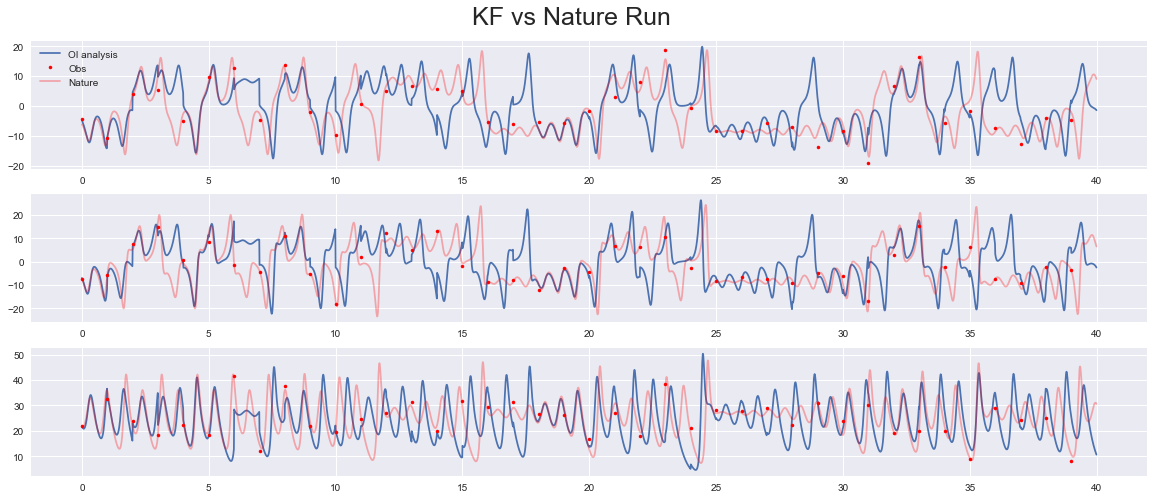

In [21]:
print('========Some Parameters=========')
print(f'cycle length (time interval between two observations): {obs_timeintv} sec')
print(f'number of cycle: {cycle_num}')
print(f'dt = {dt} sec')
print(f'initial value for experiment: {X_ini.ravel()}')
print(f'initial value for nature run: {X_nature[:,0]}')
print('=================================')

alpha = 0.6  # relaxation

cycle_len = obs_timeintv
result = np.zeros((X_ini.size, int(cycle_len*cycle_num/dt)))
xb = X_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

# start cycle assimilation
for nc in range(cycle_num):
    print('=== Pb ===')
    print(Pb)
    # calculate analysis field, then forecast
    xa, Pa = OI(xb, X_obs[:,[nc]], Pb, R)
    x = lorenz63_fdm(xa.ravel(), ts)
    result[:,int(nc*cycle_len/dt):int((nc+1)*cycle_len/dt)] = x
    print('=== Pa ===')
    print(Pa)
        
    # for next cycle
    #Pb = 100 * M(xb[0,0], xb[1,0], xb[2,0], dt) @ Pa @ M(xb[0,0], xb[1,0], xb[2,0], dt).T
    Pb = alpha * Pb + (1-alpha) * M(xb[0,0], xb[1,0], xb[2,0], dt) @ Pa @ M(xb[0,0], xb[1,0], xb[2,0], dt).T
    xb = x[:,[-1]]
    t_start = int(ts[-1] + dt)
    ts = np.arange(t_start, t_start+cycle_len, dt)
    
    
# plot assimilation result
ts = np.arange(0, time, dt)
t_obs = np.arange(0, time, obs_timeintv)

fig2, axs = plt.subplots(nrows=3, figsize=(20, 8))
for i in range(3):
    axs[i].plot(ts, result[i,:], label='OI analysis')
    axs[i].plot(t_obs, X_obs[i,:], 'r.', label='Obs')
    axs[i].plot(ts, X_nature[i,:], color='red', alpha=0.3, label='Nature')
    
axs[0].legend()

fig2.suptitle('KF vs Nature Run', fontsize=25, y=0.94);